In [ ]:
!pip3 install nltk
!pip3 install gensim

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import LSTM,Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
from nltk import word_tokenize

from gensim.models import Word2Vec

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('/content/drive/MyDrive/tp_LAB/FinalTrainTest.csv')
df_val = pd.read_csv('/content/drive/MyDrive/tp_LAB/FinalValSet.csv')

In [3]:
df['Target'] = df['Target'].str.strip()
df['Target'] = df['Target'].str.replace('Nuetral','Neutral')

df_val['Target'] = df_val['Target'].str.strip()
df_val['Target'] = df_val['Target'].str.replace('Nuetral','Neutral')

In [4]:
df["Target"].loc[df["Target"]=="Negative"]=0.0
df["Target"].loc[df["Target"]=="Positive"]=1.0
df["Target"].loc[df["Target"]=="Neutral"]=2.0

df_val["Target"].loc[df_val["Target"]=="Negative"]=0.0
df_val["Target"].loc[df_val["Target"]=="Positive"]=1.0
df_val["Target"].loc[df_val["Target"]=="Neutral"]=2.0

In [5]:
all_df = pd.concat([df,df_val], ignore_index=True)

In [6]:
batch_size = 32

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

# TF-IDF

In [7]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(all_df['Phrase']).toarray()
X = X[:, :, None]

In [8]:
df_1 = X[:5032]
df_val_2 = X[5032:]

In [9]:
y = df['Target']
X_train,X_test,y_train,y_test = train_test_split(df_1,y,test_size = 0.3)

In [10]:
y_train = y_train.to_numpy().astype(np.float64)
y_test = y_test.to_numpy().astype(np.float64)

In [11]:
X_validation = df_val_2
y_validation = df_val['Target'].to_numpy().astype(np.float64)

In [12]:
dim_vocabulary = len(vectorizer.vocabulary_)

<h2>Hybrid model</h2>

In [13]:
hybrid_model = Sequential([
    Embedding(input_dim=dim_vocabulary,output_dim=batch_size,input_length=X_train.shape[1:][0]),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    LSTM(100),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [14]:
hybrid_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8109, 32)          259488    
                                                                 
 conv1d (Conv1D)             (None, 8109, 32)          3104      
                                                                 
 batch_normalization (BatchN  (None, 8109, 32)         128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4054, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4054, 16)          1552      
                                                                 
 batch_normalization_1 (Batc  (None, 4054, 16)         6

In [15]:
hybrid_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [16]:
history = hybrid_model.fit(X_train, y_train, epochs=50, batch_size=batch_size,callbacks = [early_stopping],validation_data=(X_test,y_test))

Epoch 1/50
111/111 [==============================] - 17s 106ms/step - loss: 1.0990 - accuracy: 0.3362 - val_loss: 1.0986 - val_accuracy: 0.3338
Epoch 2/50
111/111 [==============================] - 11s 99ms/step - loss: 1.0995 - accuracy: 0.3328 - val_loss: 1.0989 - val_accuracy: 0.3338
Epoch 3/50
111/111 [==============================] - 11s 100ms/step - loss: 1.0993 - accuracy: 0.3365 - val_loss: 1.0987 - val_accuracy: 0.3338
Epoch 4/50
111/111 [==============================] - 11s 100ms/step - loss: 1.0996 - accuracy: 0.3421 - val_loss: 1.0983 - val_accuracy: 0.3437
Epoch 5/50
111/111 [==============================] - 11s 100ms/step - loss: 1.0997 - accuracy: 0.3279 - val_loss: 1.1012 - val_accuracy: 0.3437
Epoch 6/50
111/111 [==============================] - 11s 100ms/step - loss: 1.0994 - accuracy: 0.3217 - val_loss: 1.1010 - val_accuracy: 0.3338
Epoch 7/50
111/111 [==============================] - 11s 99ms/step - loss: 1.0988 - accuracy: 0.3228 - val_loss: 1.0987 - val_accu

In [17]:
hybrid_model.evaluate(X_validation, y_validation)

4/4 [==============================] - 0s 79ms/step - loss: 1.0959 - accuracy: 0.4000


[1.0959030389785767, 0.4000000059604645]

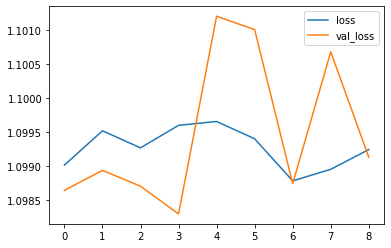

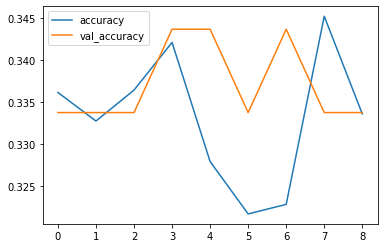

In [18]:
model_history = pd.DataFrame(history.history)
model_history.loc[:, ['loss', 'val_loss']].plot()
model_history.loc[:, ['accuracy', 'val_accuracy']].plot()

<h2>LSTM</h2>

In [14]:
lstm_model = Sequential([
    Embedding(dim_vocabulary, batch_size,input_length=X_train.shape[1:][0]),
    LSTM(100),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [15]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8109, 32)          259488    
                                                                 
 lstm_1 (LSTM)               (None, 100)               53200     
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dropout_4 (Dropout)         (None, 100)              

In [16]:
lstm_model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

In [17]:
history_lstm = lstm_model.fit(X_train, y_train, epochs=50, batch_size=batch_size,callbacks=[early_stopping],validation_data=(X_test,y_test))

Epoch 1/50
111/111 [==============================] - 40s 308ms/step - loss: 1.0994 - accuracy: 0.3350 - val_loss: 1.0989 - val_accuracy: 0.3344
Epoch 2/50
111/111 [==============================] - 34s 306ms/step - loss: 1.1007 - accuracy: 0.3328 - val_loss: 1.0998 - val_accuracy: 0.3212
Epoch 3/50
111/111 [==============================] - 34s 305ms/step - loss: 1.0995 - accuracy: 0.3257 - val_loss: 1.0985 - val_accuracy: 0.3344
Epoch 4/50
111/111 [==============================] - 38s 339ms/step - loss: 1.1001 - accuracy: 0.3197 - val_loss: 1.0988 - val_accuracy: 0.3344
Epoch 5/50
111/111 [==============================] - 34s 305ms/step - loss: 1.0989 - accuracy: 0.3296 - val_loss: 1.0989 - val_accuracy: 0.3344
Epoch 6/50
111/111 [==============================] - 34s 303ms/step - loss: 1.0990 - accuracy: 0.3410 - val_loss: 1.0986 - val_accuracy: 0.3344


In [18]:
lstm_model.evaluate(X_validation, y_validation)

4/4 [==============================] - 1s 124ms/step - loss: 1.0976 - accuracy: 0.4000


[1.0975534915924072, 0.4000000059604645]

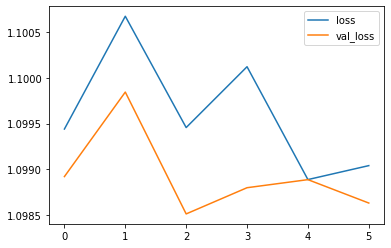

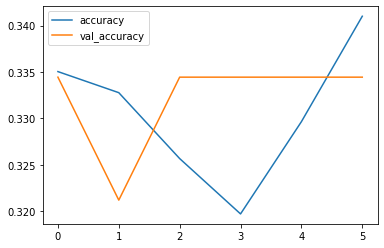

In [19]:
model_history = pd.DataFrame(history_lstm.history)
model_history.loc[:, ['loss', 'val_loss']].plot()
model_history.loc[:, ['accuracy', 'val_accuracy']].plot()

# Word2Vec

In [7]:
sentences=[]
sum=0
for tweet in all_df['Phrase']:
    sents=word_tokenize(tweet)
    sum+=len(sents)
    sentences.append(sents) 

print(sum)
print(len(sentences))  

58162
5157


In [8]:
for te in sentences[:5]:
    print(te,"\n")

['lonely', 'best', 'way', 'focus', 'become', 'stronger', 'man', 'let', 'faith'] 

['call', 'keith', 'mystery'] 

['long', 'road', 'lonely', 'one', 'still', 'find', 'answers', 'im', 'chosen', 'one', 'promise'] 

['ship', 'chaos', 'escape', 'futile', 'emergency', 'repair', 'result', 'failure', 'fuels', 'exploding', 'survival', 'hopeless'] 

['ladies', 'lonely', 'come', 'keep', 'company'] 



In [9]:
w2v_model = Word2Vec(sentences=sentences,size=300,window=10,min_count=1)

In [10]:
w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

(526192, 581620)

In [11]:
vocab=w2v_model.wv.vocab
print("The total number of words are : ",len(vocab))

The total number of words are :  8154


In [12]:
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict))

The no of key-value pairs :  8154


In [13]:
tok = Tokenizer()
tok.fit_on_texts(all_df['Phrase'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(all_df['Phrase'])

In [14]:
pad_rev= pad_sequences(encd_rev)
pad_rev.shape 

(5157, 43)

In [15]:
df_1 = pad_rev[:5032]
df_val_2 = pad_rev[5032:]

In [16]:
y = df['Target']
X_train,X_test,y_train,y_test = train_test_split(df_1,y,test_size = 0.3)

In [17]:
y_train = y_train.to_numpy().astype(np.float64)
y_test = y_test.to_numpy().astype(np.float64)

In [18]:
X_validation= df_val_2
X_validation.shape 

(125, 43)

In [19]:
y_validation = df_val['Target'].to_numpy().astype(np.float64)
y_validation.shape

(125,)

In [20]:
embed_matrix=np.zeros(shape=(vocab_size,300))
for word,i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:  
    embed_matrix[i]=embed_vector

<h2>Hybrid model</h2>

In [21]:
hybrid_model = Sequential([
    Embedding(input_dim=vocab_size,output_dim=300,input_length=43,embeddings_initializer=Constant(embed_matrix)),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    LSTM(100),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [22]:
hybrid_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 43, 300)           2445300   
                                                                 
 conv1d (Conv1D)             (None, 43, 32)            28832     
                                                                 
 batch_normalization (BatchN  (None, 43, 32)           128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 21, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 16)            1552      
                                                                 
 batch_normalization_1 (Batc  (None, 21, 16)           6

In [23]:
hybrid_model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

In [24]:
history = hybrid_model.fit(X_train, y_train, epochs=50, batch_size=batch_size,callbacks = [early_stopping],validation_data=(X_test,y_test))

Epoch 1/50
111/111 [==============================] - 7s 15ms/step - loss: 1.0802 - accuracy: 0.3904 - val_loss: 1.0419 - val_accuracy: 0.4616
Epoch 2/50
111/111 [==============================] - 1s 9ms/step - loss: 1.0250 - accuracy: 0.4671 - val_loss: 0.9866 - val_accuracy: 0.5079
Epoch 3/50
111/111 [==============================] - 1s 9ms/step - loss: 0.8560 - accuracy: 0.5818 - val_loss: 1.0032 - val_accuracy: 0.4768
Epoch 4/50
111/111 [==============================] - 1s 9ms/step - loss: 0.6017 - accuracy: 0.7467 - val_loss: 0.8117 - val_accuracy: 0.6205
Epoch 5/50
111/111 [==============================] - 1s 9ms/step - loss: 0.4185 - accuracy: 0.8455 - val_loss: 0.6618 - val_accuracy: 0.7278
Epoch 6/50
111/111 [==============================] - 1s 9ms/step - loss: 0.3089 - accuracy: 0.9043 - val_loss: 0.7985 - val_accuracy: 0.7258
Epoch 7/50
111/111 [==============================] - 1s 9ms/step - loss: 0.2028 - accuracy: 0.9387 - val_loss: 0.7745 - val_accuracy: 0.7682
Epoch

In [25]:
hybrid_model.evaluate(X_validation, y_validation)

4/4 [==============================] - 0s 19ms/step - loss: 2.4606 - accuracy: 0.4720


[2.4605824947357178, 0.47200000286102295]

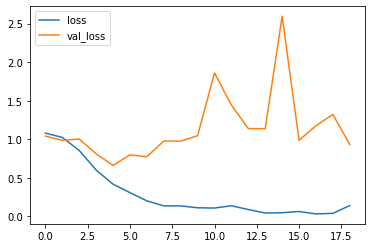

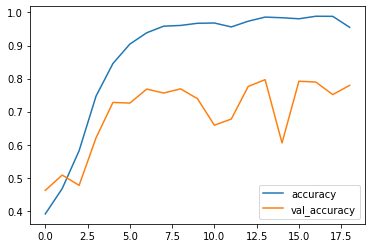

In [26]:
model_history = pd.DataFrame(history.history)
model_history.loc[:, ['loss', 'val_loss']].plot()
model_history.loc[:, ['accuracy', 'val_accuracy']].plot()

<h2>LSTM</h2>

In [21]:
lstm_model = Sequential([
    Embedding(input_dim=vocab_size,output_dim=300,input_length=43,embeddings_initializer=Constant(embed_matrix)),
    LSTM(100),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [22]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 43, 300)           2445300   
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0

In [23]:
lstm_model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

In [24]:
history_lstm = lstm_model.fit(X_train, y_train, epochs=50, batch_size=batch_size,callbacks=[early_stopping],validation_data=(X_test,y_test))

Epoch 1/50
111/111 [==============================] - 5s 15ms/step - loss: 1.1016 - accuracy: 0.3629 - val_loss: 1.0947 - val_accuracy: 0.3318
Epoch 2/50
111/111 [==============================] - 1s 8ms/step - loss: 1.0787 - accuracy: 0.4182 - val_loss: 1.0498 - val_accuracy: 0.5079
Epoch 3/50
111/111 [==============================] - 1s 8ms/step - loss: 0.9175 - accuracy: 0.5656 - val_loss: 0.8676 - val_accuracy: 0.5861
Epoch 4/50
111/111 [==============================] - 1s 10ms/step - loss: 0.6398 - accuracy: 0.7215 - val_loss: 0.7305 - val_accuracy: 0.6940
Epoch 5/50
111/111 [==============================] - 1s 8ms/step - loss: 0.3463 - accuracy: 0.8796 - val_loss: 0.9977 - val_accuracy: 0.7212
Epoch 6/50
111/111 [==============================] - 1s 8ms/step - loss: 0.2241 - accuracy: 0.9319 - val_loss: 0.8675 - val_accuracy: 0.7762
Epoch 7/50
111/111 [==============================] - 1s 8ms/step - loss: 0.1323 - accuracy: 0.9625 - val_loss: 1.1077 - val_accuracy: 0.7570
Epoc

In [25]:
lstm_model.evaluate(X_validation, y_validation)

4/4 [==============================] - 0s 6ms/step - loss: 5.8020 - accuracy: 0.4800


[5.801957130432129, 0.47999998927116394]

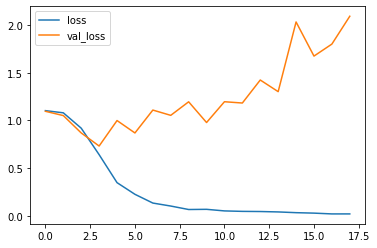

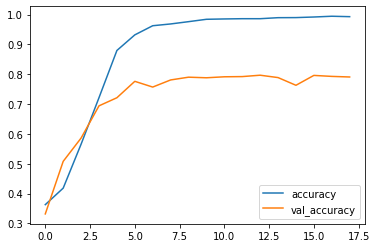

In [26]:
model_history = pd.DataFrame(history_lstm.history)
model_history.loc[:, ['loss', 'val_loss']].plot()
model_history.loc[:, ['accuracy', 'val_accuracy']].plot()